### 【問題1】機械翻訳の実行とコードリーディング
Keras公式のサンプルコードで、短い英語からフランス語への変換を行うものが公開されています。これを動かしてください。

[keras/lstm_seq2seq.py at master · keras-team/keras](https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py)

その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。

（例）

- 51から55行目 : ライブラリのimport
- 57から62行目 : ハイパーパラメータの設定

《文字単位のトークン化》

この実装ではテキストのベクトル化の際に、単語ではなく文字ごとを1つのトークンとして扱っています。

scikit-learnでBoWを計算するCountVectorizerの場合では、デフォルトの引数はanalyzer=’word’で単語を扱いますが、charやchar_wbとすることで文字を扱えるようになります。

charとchar_wbの2種類の方法があり、char_wbを指定した場合、n_gramが単語内からのみ作成されます。逆にcharは単語の区切りが関係なくn_gramが作成されます。This movie is very good.というテキストを3-gramでカウントする時、charではs mやe iといった単語をまたぐ数え方もしますが、char_wbではこれらを見ません。

[sklearn.feature_extraction.text.CountVectorizer — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

#### 回答について
コードの各部分の役割については、以下の書き方でコード内にコメントで記載する。

####### 処理内容 #######

In [4]:
'''
#Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
**Summary of the algorithm**
- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
**Data download**
[English to French sentence pairs.
](http://www.manythings.org/anki/fra-eng.zip)
[Lots of neat sentence pairs datasets.
](http://www.manythings.org/anki/)
**References**
- [Sequence to Sequence Learning with Neural Networks
   ](https://arxiv.org/abs/1409.3215)
- [Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    ](https://arxiv.org/abs/1406.1078)
'''
from __future__ import print_function

####### ライブラリのインポート #######
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

####### パラメータの設定 #######
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'

# Vectorize the data.
####### 入力・ラベルを格納するリスト #######
input_texts = []
target_texts = []
####### 入力・ラベルに含まれる文字の集合 #######
input_characters = set()
target_characters = set()
####### ファイル読み込み #######
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
####### ファイルから１行ずつ読み込み、入力・ラベルのリストと文字集合を作成する #######
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

####### 文字コード順にソート #######
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
####### トークンの数 #######
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
####### 入力・ラベルそれぞれの最大トークン数 #######
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

####### 表示 #######
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

####### 文字を文字IDに変換する辞書 #######
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

####### エンコーダ・デコーダに入力するデータの領域を作成 #######
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

####### データを作成。領域の末端の次元がトークンの種類数なので、各トークンがあるかないかを示すone-hotで作成している #######
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
####### エンコーダのモデルを作成#######
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

####### デコーダのモデルを作成 #######
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

####### 学習用モデルを作成 #######
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

####### モデルを学習・重みを保存 #######
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
####### エンコーダの隠れ状態・セル状態を出力するまでのモデルを作成 #######
encoder_model = Model(encoder_inputs, encoder_states)

####### 隠れ状態・セル状態とデータを入力とし、系列を出力するモデルを作成 #######
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
####### 文字IDを文字に変換する辞書を作成 #######
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


####### one-hotの系列を入力し、翻訳された文字列を返す関数 #######
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    ####### 隠れ状態・セルを導出 #######
    states_value = encoder_model.predict(input_seq)

    ####### 予測される文字を順次格納しておく領域 #######
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        ####### 隠れ状態・セルと、次に予測される単語の確率を求める #######
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        ####### 最も確率の高い文字のインデックスを取得し、文字に変換する #######
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        ####### 無限ループを止める #######
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        ####### 次の予測に使用できるよう、予測された文字のインデックスを1にしておく #######
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        ####### 次の時刻に渡す隠れ状態・セルを更新 #######
        states_value = [h, c]

    ####### りたーん #######
    return decoded_sentence

####### １００回予測する #######
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    ####### １文を取り出す #######
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    ####### 翻訳する #######
    decoded_sentence = decode_sequence(input_seq)
    ####### 結果を表示する #######
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)
    
####### 終わり #######

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 5s 591us/step - loss: 1.1774 - accuracy: 0.7255 - val_loss: 1.0694 - val_accuracy: 0.7024
Epoch 2/100
8000/8000 [==============================] - 4s 518us/step - loss: 0.8424 - accuracy: 0.7718 - val_loss: 0.8202 - val_accuracy: 0.7732
Epoch 3/100
8000/8000 [==============================] - 4s 515us/step - loss: 0.6755 - accuracy: 0.8097 - val_loss: 0.7208 - val_accuracy: 0.7903
Epoch 4/100
8000/8000 [==============================] - 4s 518us/step - loss: 0.5939 - accuracy: 0.8276 - val_loss: 0.6508 - val_accuracy: 0.8091
Epoch 5/100
8000/8000 [==============================] - 4s 522us/step - loss: 0.5451 - accuracy: 0.8414 - val_loss: 0.6140 - val_accuracy: 0.8197
Epoch 6/100
8000/8000 [=============================

## 3.イメージキャプショニング

他の活用例としてイメージキャプショニングがあります。画像に対する説明の文章を推定するタスクです。これは画像を入力し、系列データを出力する Image to Sequence の手法によって行えます。

[pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning)

イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。

### 【問題2】イメージキャプショニングの学習済みモデルの実行
上記実装において 5. Test the model の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。

データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。

注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。

In [2]:
cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

/media/timanishi/Programing/2020/Dive_Into_Code/diveintocode-ml/Sprint/24/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [3]:
pwd

'/media/timanishi/Programing/2020/Dive_Into_Code/diveintocode-ml/Sprint/24/pytorch-tutorial/tutorials/03-advanced/image_captioning'

In [13]:
import cv2
from matplotlib import pyplot as plt

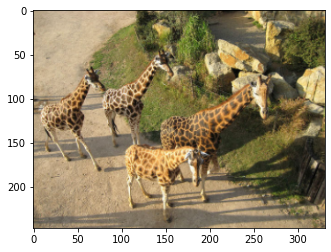

In [23]:
img = cv2.imread('png/example.png', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [24]:
!python sample.py --image='png/example.png'

<start> a group of giraffes standing next to each other . <end>


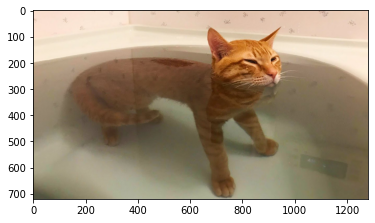

In [25]:
img = cv2.imread('png/cat_1.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [26]:
!python sample.py --image='png/cat_1.jpg'

<start> a cat is sitting on a toilet seat . <end>


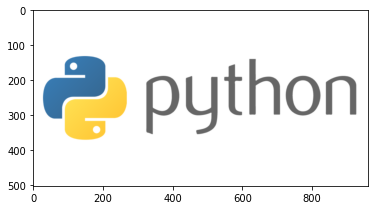

In [29]:
img = cv2.imread('png/python.png', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [30]:
!python sample.py --image='png/python.png'

<start> a person holding a pair of scissors in front of a blue wall . <end>


### 【問題3】Kerasで動かしたい場合はどうするかを調査
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。

特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

- MMdnnでpytorchのモデルをKeras用に変換する。
  - 事前学習された重みは`torch.save(the_model.state_dict(), PATH)`の形式で保存されているものでMMdnnで変換が出来ないため、`torch.save(the_model, PATH)`の形式でモデルを保存する。
  - `mmconvert -sf pytorch -iw models/decoder-5-3000.pth -df keras -om models/decoder-5-3000.h5`で変換する。
- torchsummaryでモデルのサマリを表示する。
- pytorchモデルのサマリに従ってKerasモデルをコーディングする。
- 変換したKerasモデルを読み込んで実行する。

### 【問題4】（アドバンス課題）コードリーディングと書き換え
モデル部分はmodel.pyに書かれていますが、Kerasではこのモデルがどのように記述できるかを考え、コーディングしてください。その際機械翻訳のサンプルコードが参考になります。

#### 回答なし

### 【問題5】（アドバンス課題）発展的調査
《他の言語の翻訳を行う場合は？》

問題1の実装を使い日本語と英語の翻訳を行いたい場合はどのような手順を踏むか考えてみましょう。

《機械翻訳の発展的手法にはどのようなものがある？》

機械翻訳のための発展的手法にはどういったものがあるか調査してみましょう。

《文章から画像生成するには？》

イメージキャプショニングとは逆に文章から画像を生成する手法もあります。どういったものがあるか調査してみましょう。

#### 回答なし